Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab_storage/src/hotels_ranking_project


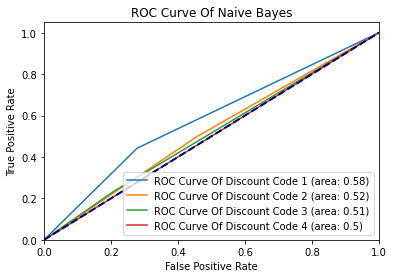

Gaussian Naive Bayes Model Accuracy: 0.442


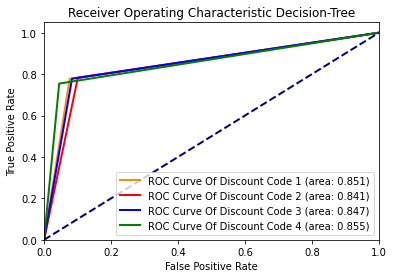

Decision Tree Model Accuracy: 0.777


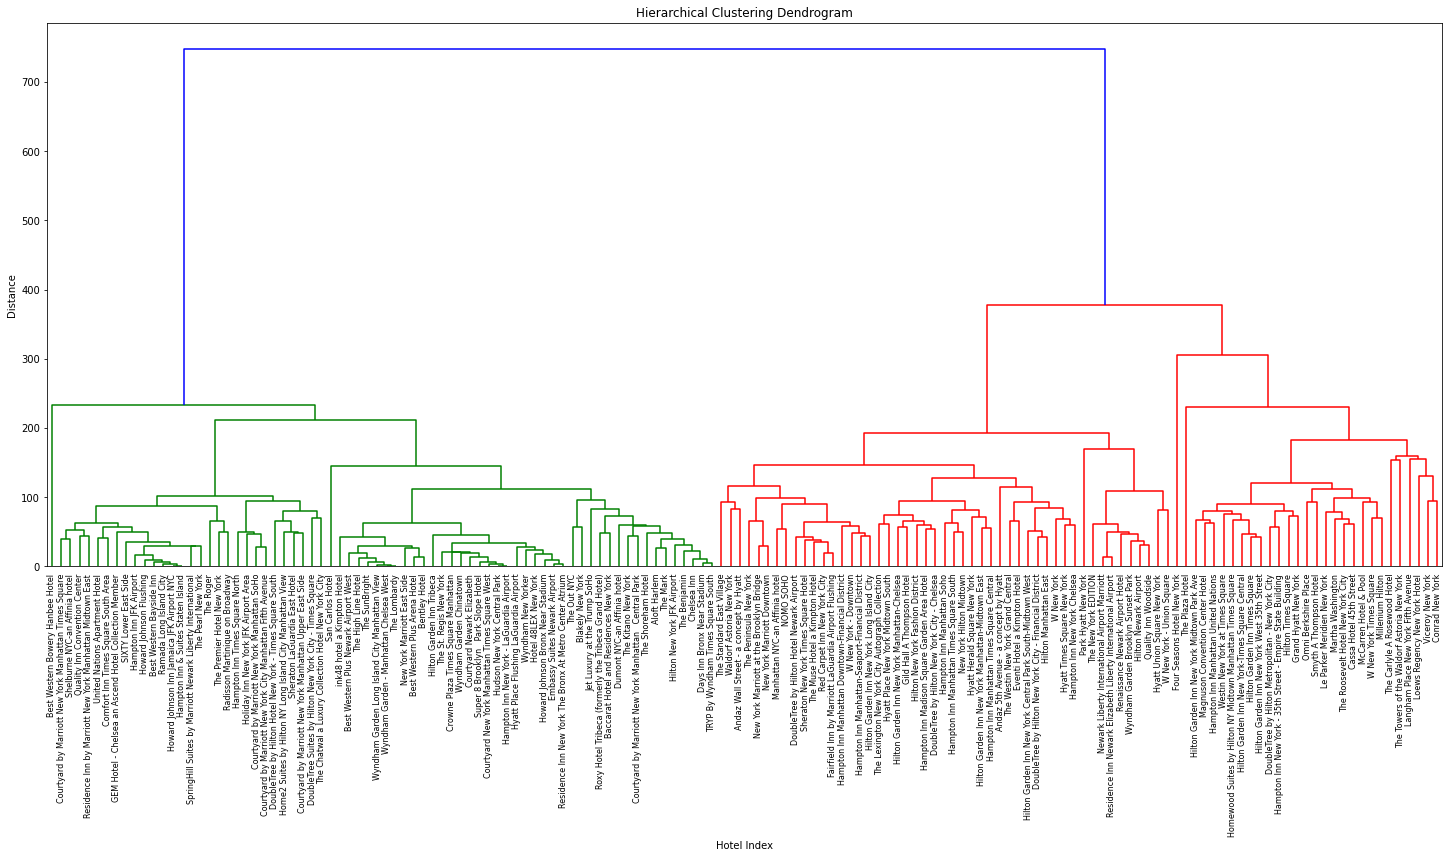

In [30]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
# %cd your/path/to/the/code/directory

from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from hotels_ranking_utils import prepare_data, load_csv, confusion_matrix, get_price_by_index, normalize
from numpy import random

random.seed(2021)

_N_CLASSES_ = 4
_DATA_FILEPATH_ = '../datasets/hotels_data.csv'

def GaussianNB_train(X_train, Y_train, n_classes, plot: bool=False) -> tuple:
  from sklearn.naive_bayes import GaussianNB

  model = GaussianNB()
  pred = model.fit(X_train, Y_train).predict(X_test)
  cmGNB = metrics.confusion_matrix(Y_test, pred)

  if plot:
    expected = label_binarize(Y_test, classes=list(range(1, n_classes + 1)))
    pred = label_binarize(pred, classes=list(range(1, n_classes + 1)))
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(expected[:, i], pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label=f"ROC Curve Of Discount Code {str(i + 1)} (area: {round(roc_auc[i], 2)})")
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Of Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()
  return cmGNB, model


def DecisionTree_train(X_train, Y_train, n_classes, plot: bool=False) -> tuple:
  from sklearn.tree import DecisionTreeClassifier

  model = DecisionTreeClassifier(criterion='entropy', max_depth=30)
  model = model.fit(X_train, Y_train)
  predictedTree = model.predict(X_test)
  cmTree = metrics.confusion_matrix(Y_test, predictedTree)

  if plot:
    y_disc_test = label_binarize(Y_test, classes=list(range(1, n_classes + 1)))
    y_score = label_binarize(predictedTree, classes=list(range(1, n_classes + 1)))
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_disc_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    fpr['micro'], tpr['micro'], _ = roc_curve(y_disc_test.ravel(), y_score.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    plt.figure()
    plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f"ROC Curve Of Discount Code 1 (area: {round(roc_auc[0], 3)})")
    plt.plot(fpr[1], tpr[1], color='red', lw=2, label=f"ROC Curve Of Discount Code 2 (area: {round(roc_auc[1], 3)})")
    plt.plot(fpr[2], tpr[2], color='blue', lw=2, label=f"ROC Curve Of Discount Code 3 (area: {round(roc_auc[2], 3)})")
    plt.plot(fpr[3], tpr[3], color='green', lw=2, label=f"ROC Curve Of Discount Code 4 (area: {round(roc_auc[3], 3)})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Decision-Tree')
    plt.legend(loc="lower right")
    plt.show()
  return cmTree, model

def agg_hotels(hotels, n_classes, plot: bool=False) -> object:
  from scipy.cluster.hierarchy import dendrogram, linkage
  from sklearn.cluster import AgglomerativeClustering
  from pandas import factorize, DataFrame
  from pandas.core.common import SettingWithCopyWarning
  import warnings
  warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

  hotels = hotels[['hotel_name','checkin_date','discount_code','discount_price']]
  factorize_checkin_date = factorize(hotels['checkin_date'])[0]
  factorize_hotal_name = factorize(hotels['hotel_name'])[0]
  hotels['hotel_name_index'] = factorize_hotal_name
  hotels['checkin_date_index'] = factorize_checkin_date

  hotels150 = hotels.groupby(['hotel_name']).size().sort_values(ascending=False)[:150].index
  hotel_name_matrix = DataFrame({
                                  'hotel_name': hotels150, 
                                  'hotel_name_index': hotels.groupby(['hotel_name_index']).size().sort_values(ascending=False)[:150].index
                                })
  filtered_hotels = hotels.loc[hotels['hotel_name'].isin(hotels150)]
  most_checkin_date_rows = filtered_hotels.groupby(['checkin_date']).size().sort_values(ascending=False)[:40]
  checkin_date_matrix = DataFrame({ 
                                    'checkin_date': most_checkin_date_rows, 
                                    'checkin_date_index': filtered_hotels.groupby(['checkin_date_index']).size().sort_values(ascending=False)[:40].index
                                  })

  cols, rows = 161, 151
  matrix = [[0 for _ in range(cols)] for _ in range(rows)]
  matrix[0][0] = 'hotel_name'
  for counter, curr_date in enumerate(most_checkin_date_rows):
    for curr_index in list(range(1, n_classes + 1)):
      matrix[0][counter + 1] = f"{curr_date}_{str(curr_index)}"
          
  for hotel_index, curr_hotel_name in enumerate(hotels150):
    matrix[hotel_index + 1][0] = curr_hotel_name
      
  for row_index in range(1, rows):
    for col_index in range(1, cols):
      matrix[row_index][col_index] = -1

  new_hotels_file = DataFrame(matrix[1:], columns=matrix[0])
  new_hotels_file = new_hotels_file.drop(new_hotels_file.filter(regex='^0').columns, axis=1)
  checkin_date_matrix = checkin_date_matrix.reset_index(drop=True)
  row_size, col_size = new_hotels_file.index.size, new_hotels_file.columns.size
  for curr_row in range(1, row_size):
    for curr_col in range(1, col_size):
      hotel_name_index = hotel_name_matrix.loc[(hotel_name_matrix['hotel_name'] == matrix[curr_row][0])]['hotel_name_index'].values[0]
      checkin_date_index = checkin_date_matrix.loc[checkin_date_matrix['checkin_date'] == int(matrix[0][curr_col].split('_')[0])]['checkin_date_index'].values[0]
      matrix[curr_row][curr_col] = get_price_by_index(hotels, hotel_name_index, checkin_date_index, int(matrix[0][curr_col].split('_')[1]))

  new_hotels_file = DataFrame(matrix[1:], columns=matrix[0])
  new_hotels_file = new_hotels_file.drop(new_hotels_file.filter(regex='^0').columns, axis=1)

  mini, maxi = matrix[1][1], matrix[1][1]
  for curr_row in range(1, row_size):
    for curr_col in range(1, col_size):
      if matrix[curr_row][curr_col] != -1:
        if mini > matrix[curr_row][curr_col]:
          mini = matrix[curr_row][curr_col]
        if maxi < matrix[curr_row][curr_col]:
          maxi = matrix[curr_row][curr_col]

  for curr_row in range(1, row_size):
    for curr_col in range(1, col_size):
      if matrix[curr_row][curr_col] != -1:
        matrix[curr_row][curr_col] = int(normalize(maxi, mini, matrix[curr_row][curr_col]))

  new_hotels_file = DataFrame(matrix[1:], columns=matrix[0])
  new_hotels_file = new_hotels_file.drop(new_hotels_file.filter(regex='^0').columns, axis=1)

  hotel_names = new_hotels_file['hotel_name'].copy()
  new_hotels_file['hotel_name'] = factorize(new_hotels_file['hotel_name'])[0]

  ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
  ward.fit(new_hotels_file)
  if plot:
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Hotel Index')
    plt.ylabel('Distance')
    dendrogram(linkage(new_hotels_file, 'ward'), leaf_rotation=90., leaf_font_size=8., leaf_label_func=lambda id: hotel_names[id])
    plt.show()
  return ward


if __name__ == '__main__':
  hotels = load_csv(_DATA_FILEPATH_)
  (_, Y_labels), (X_train, X_test, Y_train, Y_test) = prepare_data(hotels)
  cm_GNB, GNB_model = GaussianNB_train(X_train, Y_train, n_classes=_N_CLASSES_, plot=True)
  GNB_acc = confusion_matrix(cm_GNB)[0]
  print(f"Gaussian Naive Bayes Model Accuracy: {round(GNB_acc, 3)}")
  cm_DT, DT_model = DecisionTree_train(X_train, Y_train, n_classes=_N_CLASSES_, plot=True)
  DT_acc = confusion_matrix(cm_DT)[0]
  print(f"Decision Tree Model Accuracy: {round(DT_acc, 3)}")
  agg_hotels(hotels, n_classes=_N_CLASSES_, plot=True)